# Quick check for why fiducial cut is crap

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors

from typing          import Optional
from typing          import Union
from typing          import Callable

from concurrent.futures import ProcessPoolExecutor

import sys,os,os.path
from pathlib import Path
sys.path.append("/scratch/halmazan/NEXT/IC_alter-blob-centre/IC/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/scratch/halmazan/NEXT/testing/notebooks/")
os.environ['ICTDIR']='/scratch/halmazan/NEXT/IC_master/IC/'

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range
#from invisible_cities.cities.beersheba    import hitc_to_df_
from invisible_cities.io.hits_io          import hits_from_df
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.types.symbols       import NormStrategy
from invisible_cities.types.ic_types      import NoneType
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction
from invisible_cities.evm.event_model     import HitCollection

from tqdm import tqdm


import functions.functions_HE as func


In [63]:
def load_single_file(file_path):
    '''
    Load data from a single h5 file and produce dataframes for /Tracking/Tracks

    Args:
        file_path       :       str
                                Path to the h5 file to be loaded.

    Returns:
        tracks_df       :       pandas.DataFrame
                                DataFrame containing the /Tracking/Tracks data.
        failed          :       int
                                1 if the file failed to load, 0 otherwise.
    '''
    try: 
        tracks_df = load_dst(file_path, 'RECO', 'Events')
        return tracks_df, 0
    except Exception as e:
        print(f'File {file_path} broke with error:\n{e}')
        x = pd.DataFrame()
        return x, 1

def load_data_fast(folder_path):
    '''
    Load multiple h5 files and produce concatenated dataframes for /Tracking/Tracks, /MC/Particles, and their corresponding eventmap.

    Args:
        folder_path     :       str
                                Path to the folder containing the h5 files.

    Returns:
        tracks          :       pandas.DataFrame
                                Concatenated DataFrame containing the /Tracking/Tracks data from all h5 files.
        total_failures  :       int
                                Total number of failed file loads.
    '''
    
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    file_paths = [os.path.join(folder_path, f) for f in file_names]

    with ProcessPoolExecutor() as executor:
        results = list(executor.map(load_single_file, file_paths))
    
    # Separate the results into respective lists
    tracks_list, failures = zip(*results)

    tracks = pd.concat(tracks_list, axis=0, ignore_index=True)

    # Sum up the failures
    total_failures = sum(failures)

    return tracks, total_failures


In [4]:
RUN_NUMBER = '15596'
TIMESTAMP  = '355015'
CITY       = 'THEKLA'

# load in the hits of events that pass the cuts
n100_dir = f'/scratch/halmazan/NEXT/PROCESSING/topology_cuts/data/{RUN_NUMBER}/{TIMESTAMP}/cut_hdst.h5'
passing_events = pd.read_hdf(f'{n100_dir}', 'Tracking/Tracks')
display(passing_events)


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
33,1740145,0,1.609145,333.781583,389,943,1,-220.275,214.825,604.807625,...,655.325100,26.525,260.475,640.773191,0.420415,0.286382,0.0,14.714286,14.200000,14.391297
101,2451226,0,1.635652,236.838122,461,1197,1,134.375,-217.575,784.923250,...,895.209064,165.475,-63.075,819.813148,0.175732,0.103428,0.0,14.380000,14.453125,14.628139
105,2026431,0,1.588269,183.777266,335,849,1,10.975,-31.975,688.579000,...,735.585162,57.625,-0.875,779.465557,0.386941,0.330176,0.0,14.087500,14.200000,13.921078
116,3721047,0,1.477599,289.189144,327,857,1,10.975,-217.575,914.188125,...,936.472673,181.025,-31.975,1026.898328,0.451979,0.171932,0.0,14.446667,14.519444,14.606653
147,2251677,0,1.610797,393.729540,338,850,1,-158.075,-263.225,161.679250,...,170.669834,26.525,-139.825,403.734527,0.467710,0.182032,0.0,14.453125,14.087500,14.668178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92569,2345861,0,1.606265,278.283481,410,1042,1,104.275,-124.275,876.564625,...,1058.651572,196.575,-63.075,896.826821,0.394322,0.146304,0.0,14.087500,13.954545,14.453570
92585,283745,0,1.692208,462.654058,463,949,1,-65.775,183.725,504.871750,...,540.684003,227.675,322.675,613.647527,0.425938,0.149586,0.0,14.777083,14.446667,14.320956
92586,283836,0,1.602097,360.655349,322,774,1,-96.875,-325.425,480.677000,...,501.378406,-50.225,-202.025,717.149936,0.319074,0.315899,0.0,14.453125,14.170833,14.384333
92683,1137689,0,1.542169,184.127448,307,787,1,88.725,-356.525,715.690500,...,796.077719,134.375,-247.675,736.231784,0.426922,0.345091,0.0,14.296429,14.170833,14.904109


## Hits first

In [40]:
# load some hits in
folder_path = f'/data/halmazan/NEXT/N100_LPR/{RUN_NUMBER}/thekla/{TIMESTAMP}/ldc1/'
holder_hits, err_hits = load_data_fast(folder_path)

In [41]:
display(holder_hits)
# events that aren't in the passing cuts
holder_hits = holder_hits[~holder_hits['event'].isin(passing_events['event'])]

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,1482027,1.752534e+09,27,23.544229,88.632726,1,-142.525,122.525,0.0,0.0,248.063375,26.627287,565.570032,-1.0,0.002752,-1,-1.0
1,1482027,1.752534e+09,27,23.544229,88.632726,1,-126.975,106.975,0.0,0.0,248.063375,14.186197,301.318271,-1.0,0.001482,-1,-1.0
2,1482027,1.752534e+09,27,23.544229,88.632726,1,-126.975,122.525,0.0,0.0,248.063375,12.856175,273.068284,-1.0,0.001356,-1,-1.0
3,1482027,1.752534e+09,27,23.544229,88.632726,1,-142.525,137.075,0.0,0.0,248.063375,10.252416,217.763795,-1.0,0.001062,-1,-1.0
4,1482027,1.752534e+09,27,23.544229,88.632726,1,-126.975,152.625,0.0,0.0,248.063375,10.326396,219.335155,-1.0,0.001070,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24672407,3399628,1.752578e+09,33,113.684653,130.482735,1,288.875,276.525,0.0,0.0,802.148250,12.866432,132.435649,-1.0,0.000741,-1,-1.0
24672408,3399628,1.752578e+09,33,113.684653,130.482735,1,304.425,276.525,0.0,0.0,802.148250,10.573542,108.834666,-1.0,0.000619,-1,-1.0
24672409,3399628,1.752578e+09,33,113.684653,130.482735,1,243.225,260.475,0.0,0.0,805.948250,12.101321,216.859024,-1.0,0.001192,-1,-1.0
24672410,3399628,1.752578e+09,33,113.684653,130.482735,1,273.325,260.975,0.0,0.0,805.948250,13.773632,246.827297,-1.0,0.001364,-1,-1.0


['event' 'time' 'npeak' 'Xpeak' 'Ypeak' 'nsipm' 'X' 'Y' 'Xrms' 'Yrms' 'Z'
 'Q' 'E' 'Qc' 'Ec' 'track_id' 'Ep']


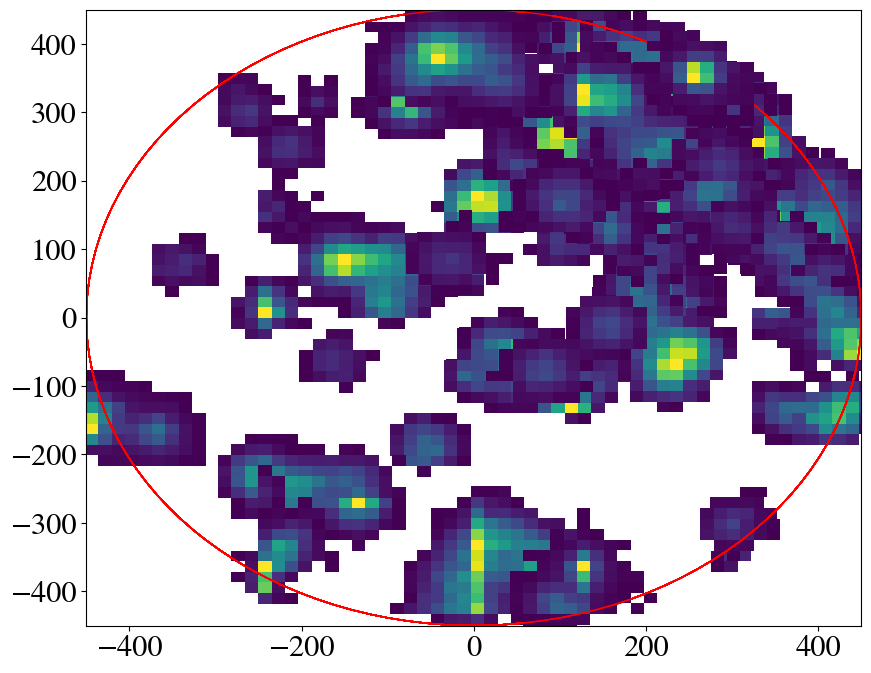

In [42]:
print(holder_hits.columns.values)
pitch = 15.55

stopper = 30


for i, (evt, df) in enumerate(holder_hits.groupby('event')):

    circle = plt.Circle((0, 0), 450, color='r', fill=False)
    plt.gca().add_artist(circle)
    xx = np.arange(df.X.min(), df.X.max() + pitch, pitch)
    yy = np.arange(df.Y.min(), df.Y.max() + pitch, pitch)

    plt.hist2d(df.X, df.Y, bins=[xx, yy], weights=df.Q, cmin=0.0001)
    
    plt.xlim([-450, 450])
    plt.ylim([-450, 450])
    #plt.title(f'{evt}')
    #plt.show()

    if i > stopper:
        break


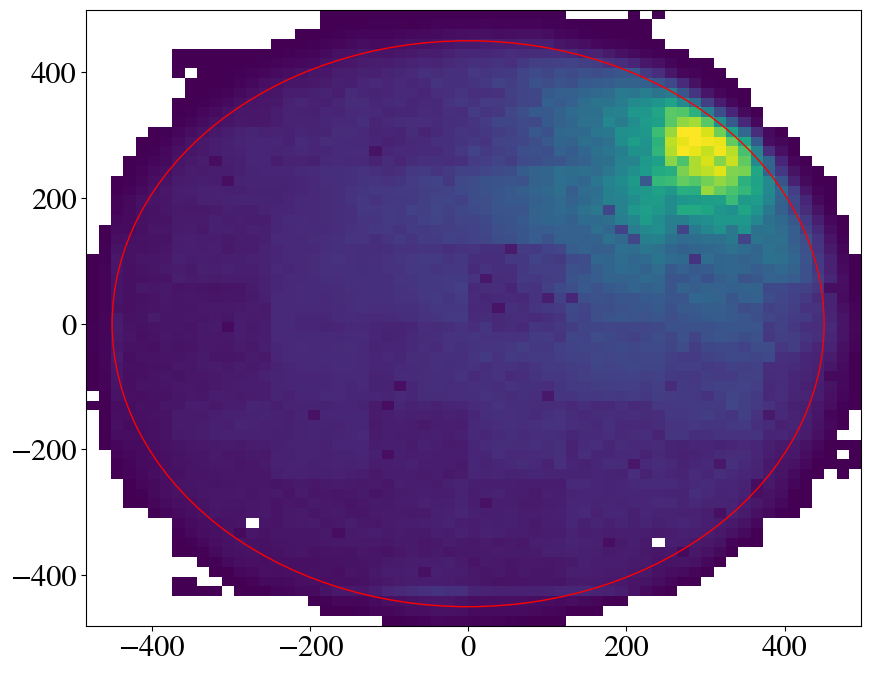

In [43]:


xx = np.arange(holder_hits.X.min(), holder_hits.X.max() + pitch, pitch)
yy = np.arange(holder_hits.Y.min(), holder_hits.Y.max() + pitch, pitch)
plt.hist2d(holder_hits.X, holder_hits.Y, bins=[xx, yy], weights=holder_hits.Q, cmin=0.0001)
circle = plt.Circle((0, 0), 450, color='r', fill=False)
plt.gca().add_artist(circle)
plt.show()

## Topological output second

In [5]:
def load_single_file_topo(file_path):
    '''
    Load data from a single h5 file and produce dataframes for /Tracking/Tracks

    Args:
        file_path       :       str
                                Path to the h5 file to be loaded.

    Returns:
        tracks_df       :       pandas.DataFrame
                                DataFrame containing the /Tracking/Tracks data.
        failed          :       int
                                1 if the file failed to load, 0 otherwise.
    '''
    try: 
        tracks_df = load_dst(file_path, 'Tracking', 'Tracks')
        return tracks_df, 0
    except Exception as e:
        print(f'File {file_path} broke with error:\n{e}')
        x = pd.DataFrame()
        return x, 1

def load_data_fast_topo(folder_path):
    '''
    Load multiple h5 files and produce concatenated dataframes for /Tracking/Tracks, /MC/Particles, and their corresponding eventmap.

    Args:
        folder_path     :       str
                                Path to the folder containing the h5 files.

    Returns:
        tracks          :       pandas.DataFrame
                                Concatenated DataFrame containing the /Tracking/Tracks data from all h5 files.
        total_failures  :       int
                                Total number of failed file loads.
    '''
    
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    file_paths = [os.path.join(folder_path, f) for f in file_names]

    with ProcessPoolExecutor() as executor:
        results = list(executor.map(load_single_file_topo, file_paths))
    
    # Separate the results into respective lists
    tracks_list, failures = zip(*results)

    tracks = pd.concat(tracks_list, axis=0, ignore_index=True)

    # Sum up the failures
    total_failures = sum(failures)

    return tracks, total_failures


In [6]:
# load some hits in
folder_path = f'/data/halmazan/NEXT/N100_LPR/{RUN_NUMBER}/thekla/{TIMESTAMP}/ldc1/'
holder, err = load_data_fast_topo(folder_path)

File /data/halmazan/NEXT/N100_LPR/15596/thekla/355015/ldc1/run_15596_1859_ldc1_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15596/thekla/355015/ldc1/run_15596_3757_ldc1_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15596/thekla/355015/ldc1/run_15596_4053_ldc1_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15596/thekla/355015/ldc1/run_15596_4295_ldc1_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15596/thekla/355015/ldc1/run_15596_4373_ldc1_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15596/thekla/355015/ldc1/run_15596_3189_ldc1_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking`

In [10]:
# plot some of the spatial variables
display(holder)
print(holder.columns)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,1482027,0,0.985860,113.591481,132,373,4,243.225,292.075,275.618250,...,285.229803,288.875,353.275,327.626870,0.428701,0.332678,0.018279,14.875455,14.939063,14.487727
1,1482027,1,0.392764,70.397433,38,112,4,-451.525,-78.125,531.491375,...,547.574235,-420.425,-48.025,547.574235,0.366764,0.366764,0.366764,14.875455,14.939063,14.487727
2,1482027,2,0.271267,70.397433,34,95,4,-173.625,91.425,248.063375,...,268.292343,-142.525,122.525,268.292343,0.242260,0.242260,0.242260,14.875455,14.939063,14.487727
3,1482027,3,0.036547,14.939063,2,4,4,-359.225,45.275,503.589375,...,506.558313,-359.225,45.275,506.558313,0.036547,0.036547,0.036547,14.875455,14.939063,14.487727
4,1482062,0,1.546171,138.962792,232,666,6,-3.575,-217.575,434.092500,...,470.548557,73.175,-170.925,501.946438,0.548517,0.486849,0.018693,14.573684,14.517647,14.613565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91939,3399264,1,0.214045,61.613764,21,57,4,73.175,75.875,1779.614750,...,1794.556444,104.275,106.975,1794.556444,0.203996,0.203996,0.203996,14.898333,14.765217,14.918833
91940,3399264,2,0.153188,44.695000,8,33,4,-19.125,75.875,280.916250,...,288.339102,10.975,91.425,288.339102,0.153188,0.153188,0.153188,14.898333,14.765217,14.918833
91941,3399264,3,0.122523,40.505139,11,30,4,366.625,137.575,480.417125,...,500.615313,381.175,153.125,500.615313,0.122523,0.122523,0.122523,14.898333,14.765217,14.918833
91942,3399369,0,1.626663,235.949351,366,922,1,-467.075,45.275,903.925500,...,993.315378,-373.775,214.325,922.955653,0.513644,0.251846,0.000000,14.170833,14.575000,13.715792


Index(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'r_min',
       'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'r_ave',
       'extreme1_x', 'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y',
       'extreme2_z', 'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y',
       'blob2_z', 'eblob1', 'eblob2', 'ovlp_blob_energy', 'vox_size_x',
       'vox_size_y', 'vox_size_z'],
      dtype='object')


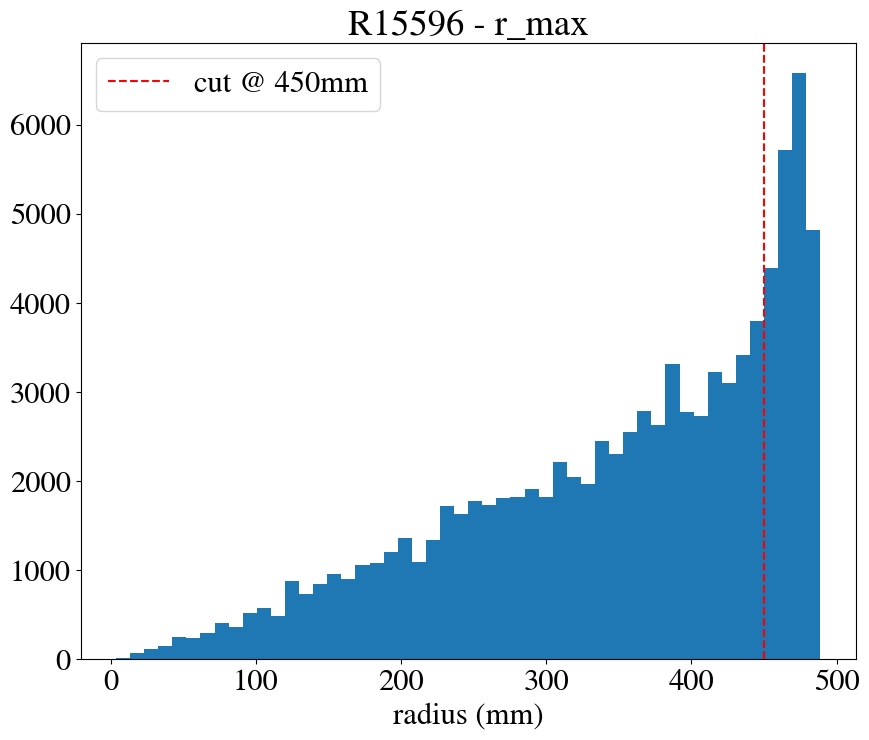

In [26]:
r_cut = 450

variable = 'r_max'

plt.hist(holder[variable].values, bins = 50)
plt.axvline(x=r_cut, color='r', linestyle='--', label = f'cut @ {r_cut}mm')
plt.title(f'R{RUN_NUMBER} - {variable}')
plt.xlabel('radius (mm)')
plt.legend()
plt.show()

In [70]:
# how many events lost due to the r_max being above 450?
r_max_cut_upper = holder[holder.r_ave > 450]
r_max_cut = holder[~holder.event.isin(r_max_cut_upper.event.values)]
print(r_max_cut.event.nunique())
print(holder.event.nunique())

print(f'{(r_max_cut.event.nunique()/holder.event.nunique()) * 100:.2f}%')

21870
26947
81.16%


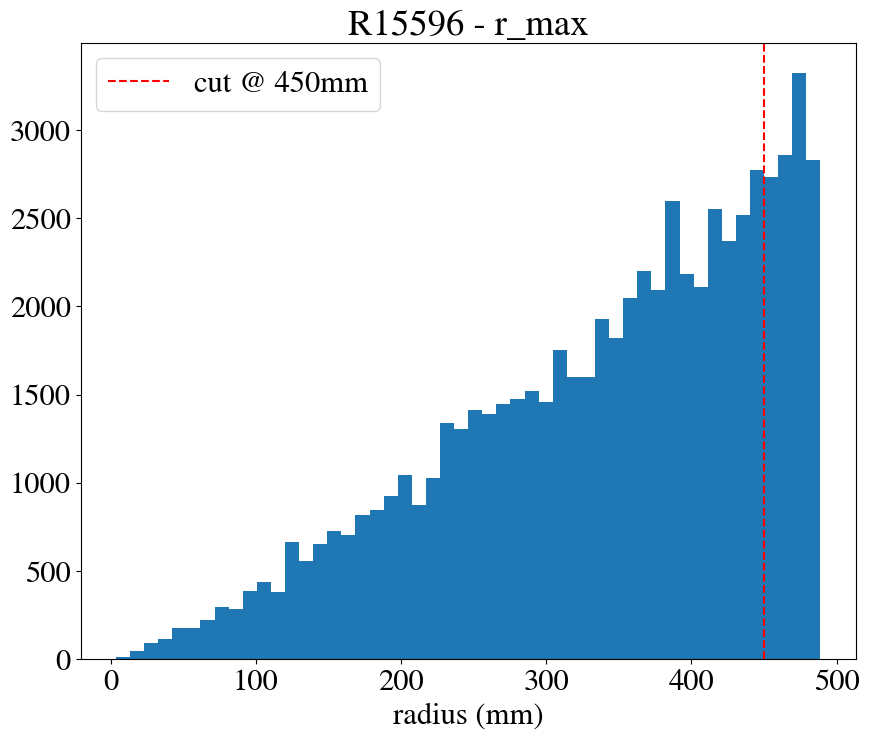

In [71]:
# validating that you did it correctly

r_cut = 450

variable = 'r_max'

plt.hist(r_max_cut[variable].values, bins = 50)
plt.axvline(x=r_cut, color='r', linestyle='--', label = f'cut @ {r_cut}mm')
plt.title(f'R{RUN_NUMBER} - {variable}')
plt.xlabel('radius (mm)')
plt.legend()
plt.show()

In [ ]:
#display(holder_hits)
r_max_hits = holder_hits[holder_hits.event.isin(holder_hits.event.values)]



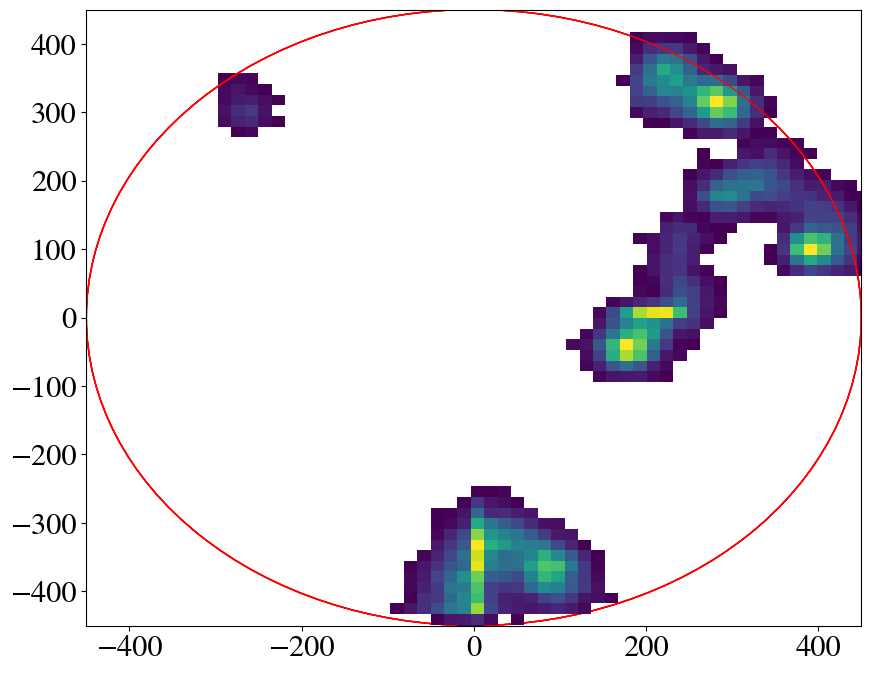

In [64]:
pitch = 15.55

stopper = 2


for i, (evt, df) in enumerate(r_max_hits.groupby('event')):

    circle = plt.Circle((0, 0), 450, color='r', fill=False)
    plt.gca().add_artist(circle)
    xx = np.arange(df.X.min(), df.X.max() + pitch, pitch)
    yy = np.arange(df.Y.min(), df.Y.max() + pitch, pitch)

    plt.hist2d(df.X, df.Y, bins=[xx, yy], weights=df.Q, cmin=0.0001)
    
    plt.xlim([-450, 450])
    plt.ylim([-450, 450])
    #plt.title(f'{evt}')
    #plt.show()

    if i > stopper:
        break


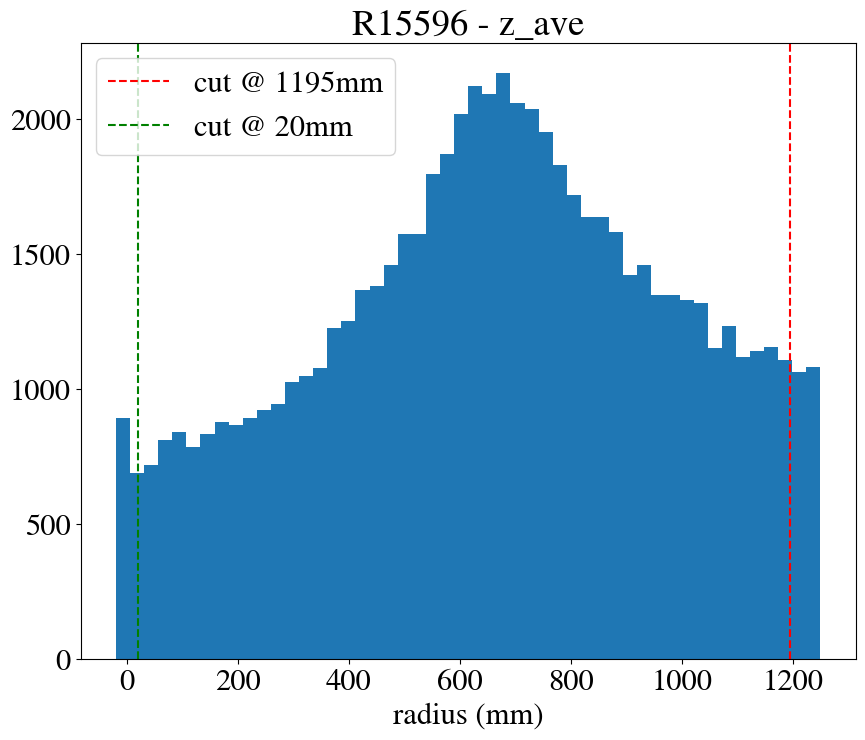

In [60]:
# look at z distribution
z_cut_upper = 1195
z_cut_lower = 20

variable = 'z_ave'

plt.hist(holder[variable].values, bins = 50, range = (-20, 1250))
plt.axvline(x=z_cut_upper, color='r', linestyle='--', label = f'cut @ {z_cut_upper}mm')
plt.axvline(x=z_cut_lower, color='g', linestyle='--', label = f'cut @ {z_cut_lower}mm')
plt.title(f'R{RUN_NUMBER} - {variable}')
plt.xlabel('radius (mm)')
plt.legend()
plt.show()

In [73]:
print('=' * 20)
print('z_max cut')
print('=' * 20)

# how many events lost due to the z_min and z_max?
z_max_cut_upper = holder[holder.z_max > z_cut_upper]
z_max_cut = holder[~holder.event.isin(z_max_cut_upper.event.values)]
#print(z_max_cut.event.nunique())
#print(holder.event.nunique())

print('Independent cut')
print(f'{(z_max_cut.event.nunique()/holder.event.nunique()) * 100:.2f}%')

# and if its done to the r_max cut
z_max_cut_upper = r_max_cut[r_max_cut.z_max > z_cut_upper]
z_max_cut = r_max_cut[~r_max_cut.event.isin(z_max_cut_upper.event.values)]

print('Relative cut (r_max cut first)')
print(f'{(z_max_cut.event.nunique()/r_max_cut.event.nunique()) * 100:.2f}%')


print('=' * 20)
print('z_min cut')
print('=' * 20)

# how many events lost due to the z_min and z_max?
z_min_cut_lower = holder[holder.z_min < z_cut_lower]
z_min_cut = holder[~holder.event.isin(z_min_cut_lower.event.values)]
#print(z_max_cut.event.nunique())
#print(holder.event.nunique())

print('Independent cut')
print(f'{(z_min_cut.event.nunique()/holder.event.nunique()) * 100:.2f}%')

# and if its done to the r_max cut
z_min_cut_lower = z_max_cut[z_max_cut.z_min < z_cut_lower]
z_min_cut = z_max_cut[~z_max_cut.event.isin(z_min_cut_lower.event.values)]

print('Relative cut (r_max cut first)')
print(f'{(z_min_cut.event.nunique()/z_max_cut.event.nunique()) * 100:.2f}%')


z_max cut
Independent cut
61.77%
Relative cut (r_max cut first)
65.45%
z_min cut
Independent cut
75.93%
Relative cut (r_max cut first)
76.66%
